# Импорт

Импортируем необходимые библиотеки

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
import os
import math
import string
import zipfile

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
from google.colab.patches import cv2_imshow

import tensorflow as tf
import keras.backend as K
from keras.backend import get_value, ctc_decode
from keras.models import Sequential, load_model
from keras.utils import plot_model
from keras.layers import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.optimizers import *

In [ ]:
# Чтение тестовых данных
zf = zipfile.ZipFile('/content/drive/MyDrive/Task1/test.zip')
df_test = pd.read_csv(zf.open('test.csv'))
df_test.head(10)

,name
0,0e7732f423f34b32aca941194c98d2bd.png
1,69805efa70324d98946bd8a632481d4b.png
2,6252dc0c079542ec9064e86a1e0a1e08.jpeg
3,3772c8741d4447f7a8969a9d8e3852e2.png
4,68c12be1ce4c4b5f911da76b67d175c1.png
5,42480fcaa4a2490fa6e74a161a319260.jpeg
6,f56829e6a0814938b0075d513dbef314.jpeg
7,6e5694044e38478e964296880cedcc5c.jpeg
8,bd6174210c624762abd00f340d155311.jpeg
9,1be449c7429240f28bf5212f87bd0881.jpeg


Добавление архива с изображениями

In [ ]:
zf_imgs = zipfile.ZipFile('/content/drive/MyDrive/Task1/imgs.zip')

In [ ]:
# Список имен изображений
img_list = df_test['name'].tolist()

# Загрузка данных и создание необходимых функций

In [ ]:
img_list[:10]

['0e7732f423f34b32aca941194c98d2bd.png',
 '69805efa70324d98946bd8a632481d4b.png',
 '6252dc0c079542ec9064e86a1e0a1e08.jpeg',
 '3772c8741d4447f7a8969a9d8e3852e2.png',
 '68c12be1ce4c4b5f911da76b67d175c1.png',
 '42480fcaa4a2490fa6e74a161a319260.jpeg',
 'f56829e6a0814938b0075d513dbef314.jpeg',
 '6e5694044e38478e964296880cedcc5c.jpeg',
 'bd6174210c624762abd00f340d155311.jpeg',
 '1be449c7429240f28bf5212f87bd0881.jpeg']

In [ ]:
# Функция для применения всех функций для предобработки
def preprocess(img):
  for func in [resize_n_rotate, add_adaptiveThreshold]:
    img = func(img)
  return img


# Функция для изменения размера изображения и поворота
def resize_n_rotate(img, shape_to=(128, 512)):
  if img.shape[0] > shape_to[0] or img.shape[1] > shape_to[1]:
    shrink_multiplayer = min(math.floor(shape_to[0] / img.shape[0] * 100) / 100,
                             math.floor(shape_to[1] / img.shape[1] * 100) / 100)
    img = cv2.resize(img, None,
                     fx=shrink_multiplayer,
                     fy=shrink_multiplayer,
                     interpolation=cv2.INTER_AREA)

  img = cv2.copyMakeBorder(img, math.ceil(shape_to[0]/2) - math.ceil(img.shape[0]/2),
                           math.floor(shape_to[0]/2) - math.floor(img.shape[0]/2),
                           math.ceil(shape_to[1]/2) - math.ceil(img.shape[1]/2),
                           math.floor(shape_to[1]/2) - math.floor(img.shape[1]/2),
                           cv2.BORDER_CONSTANT, value=255)
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)


# Функция для применения всех функций для предобработки изображения с рукописным текстом
def preprocess_l1(img):
  for func in [resize_n_rotate_l1, add_adaptiveThreshold]:
    img = func(img)
  return img


# Функция для изменения размера изображения с рукописным текстом и поворота
def resize_n_rotate_l1(img, shape_to=(128, 512)):
  shrink_multiplayer = min(math.floor(shape_to[0] / img.shape[0] * 100) / 100,
                                math.floor(shape_to[1] / img.shape[1] * 100) / 100)
  img = cv2.resize(img, None,
                        fx=shrink_multiplayer,
                        fy=shrink_multiplayer,
                        interpolation=cv2.INTER_AREA)

  img = cv2.copyMakeBorder(img, math.ceil(shape_to[0]/2) - math.ceil(img.shape[0]/2),
                           math.floor(shape_to[0]/2) - math.floor(img.shape[0]/2),
                           math.ceil(shape_to[1]/2) - math.ceil(img.shape[1]/2),
                           math.floor(shape_to[1]/2) - math.floor(img.shape[1]/2),
                           cv2.BORDER_CONSTANT, value=255)
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)


# Функция для изменения цвета изображения на чернобелый и уменьшения шумов
def add_adaptiveThreshold(img):
  return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10).astype('bool')



In [ ]:
alphabet = ' !%%&\'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnoprstuvwxyz«\xad°»АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё–—…€№'

# Функция получения символа по индексу в алфавите
def num_to_label(num, alphabet):
    text = ""
    for ch in num:
        if ch == len(alphabet):
          break
        else:
          text += alphabet[ch]
    return text

# Функция для раскодирования пердсказания
def decode_text(nums):
  values = get_value(
      ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                 greedy=True)[0][0])

  texts = []
  for i in range(nums.shape[0]):
    value = values[i]
    texts.append(num_to_label(value[value >= 0], alphabet))
  return texts

In [ ]:
alphabet_l1 = ' !"%\'(),-./0123456789:;?R[]bcehioprstuxy«»АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё'

# Функция для раскодирования пердсказания рукописного текст
def decode_text_l1(nums):
  values = get_value(
      ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                 greedy=True)[0][0])

  texts = []
  for i in range(nums.shape[0]):
    value = values[i]
    texts.append(num_to_label(value[value >= 0], alphabet_l1))
  return texts

# **Классификация изображений**

Определение метрик

In [ ]:
class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * K.cast(input_shape[1], 'float32')

        decode, log = K.ctc_decode(y_pred, input_length, greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, 'int32'))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, 'int32'))
        y_true_sparse = tf.sparse.retain(y_true_sparse, tf.not_equal(y_true_sparse.values, tf.math.reduce_max(y_true_sparse.values)))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(K.cast(len(y_true), 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)


def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

Загрузка модели

In [ ]:
# -------- Указать свой путь до файла Class1.h5 на гугл диске ----------
model = load_model("drive/MyDrive/Task1/Class1.h5")

print(model.summary())

Осуществляется предсказание на тестовом наборе

In [ ]:
n_test = 10000

In [ ]:
labels = []
imgs = []
for i, n in enumerate(img_list[:n_test]):
    data = zf_imgs.read("imgs/"+n)
    img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
    img1 = cv2.resize(img, (256, 64))
    img2 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img2 = cv2.resize(img2, (256, 64))
    img3 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img3 = cv2.resize(img3, (256, 64))
    img4 = cv2.rotate(img, cv2.ROTATE_180)
    img4 = cv2.resize(img4, (256, 64))
    imgs.append(img1)
    imgs.append(img2)
    imgs.append(img3)
    imgs.append(img4)

predict_dict = {}
class_pred = model.predict(np.array(imgs))
count_error = 0
for i, img in enumerate(imgs):
    if i % 4 == 3:
        p = [class_pred[i-3], class_pred[i-2],
             class_pred[i-1], class_pred[i]]
        if sum(p) > 2:
          predict_dict.update({img_list[int(i/4)]: 1})
          labels.append(1)
        else:
          predict_dict.update({img_list[int(i/4)]: 0})
          labels.append(0)

1250/1250 [==============================] - 18s 8ms/step


После предсказания формируем два набора: с печатным и с рукописным текстом

In [ ]:
printed_X_test = []

handwritten_X_test = []

for n in tqdm(img_list[:n_test]):
    data = zf_imgs.read("imgs/"+n)
    img = cv2.imdecode(np.frombuffer(data, np.uint8), 0)
    if predict_dict[n] == 0:
        printed_X_test.append(preprocess(img))
    else:
        handwritten_X_test.append(preprocess_l1(img))

100%|██████████| 10000/10000 [00:20<00:00, 496.77it/s]


# **Распознавание печатного текста**

Загрузка модели для предсказания печатного текста

In [ ]:
# -------- Указать свой путь до файла Model_L0.h5 на гугл диске ----------

model2 = load_model('drive/MyDrive/Task1/Model_L0.h5', custom_objects={'CTCLoss' : CTCLoss, 'CERMetric': CERMetric})

Предсказания текста

In [ ]:
predicts_printed = model2.predict(np.array(printed_X_test))
predicts_printed = decode_text(predicts_printed)

for i in predicts_printed[:10]:
  print(i)

136/136 [==============================] - 20s 104ms/step
Европы и мира и займут первое место в командном зачете». «
т в голову очевидное предложение: если уж с реализацией кураторск
нтариях сведений на основании требований тех, кто очитает, что в отноше
ше, во встрече с руководством ПAСП зам
Его главным действующим лицом стал Дмитрий М
удов предлагал Верховный суд. В июле прошлого года ВС предложил н
чера на ступеньках «Октября» и не мог не пожать ему ру
ах должны быть установлены специальные остановочные знаки с у
 них чуть ли не вдвое. И то были «длинные» выходные, они про
 координатора «Моссовета» Сергея Удальшова, к с


Вывод примеров распознавания

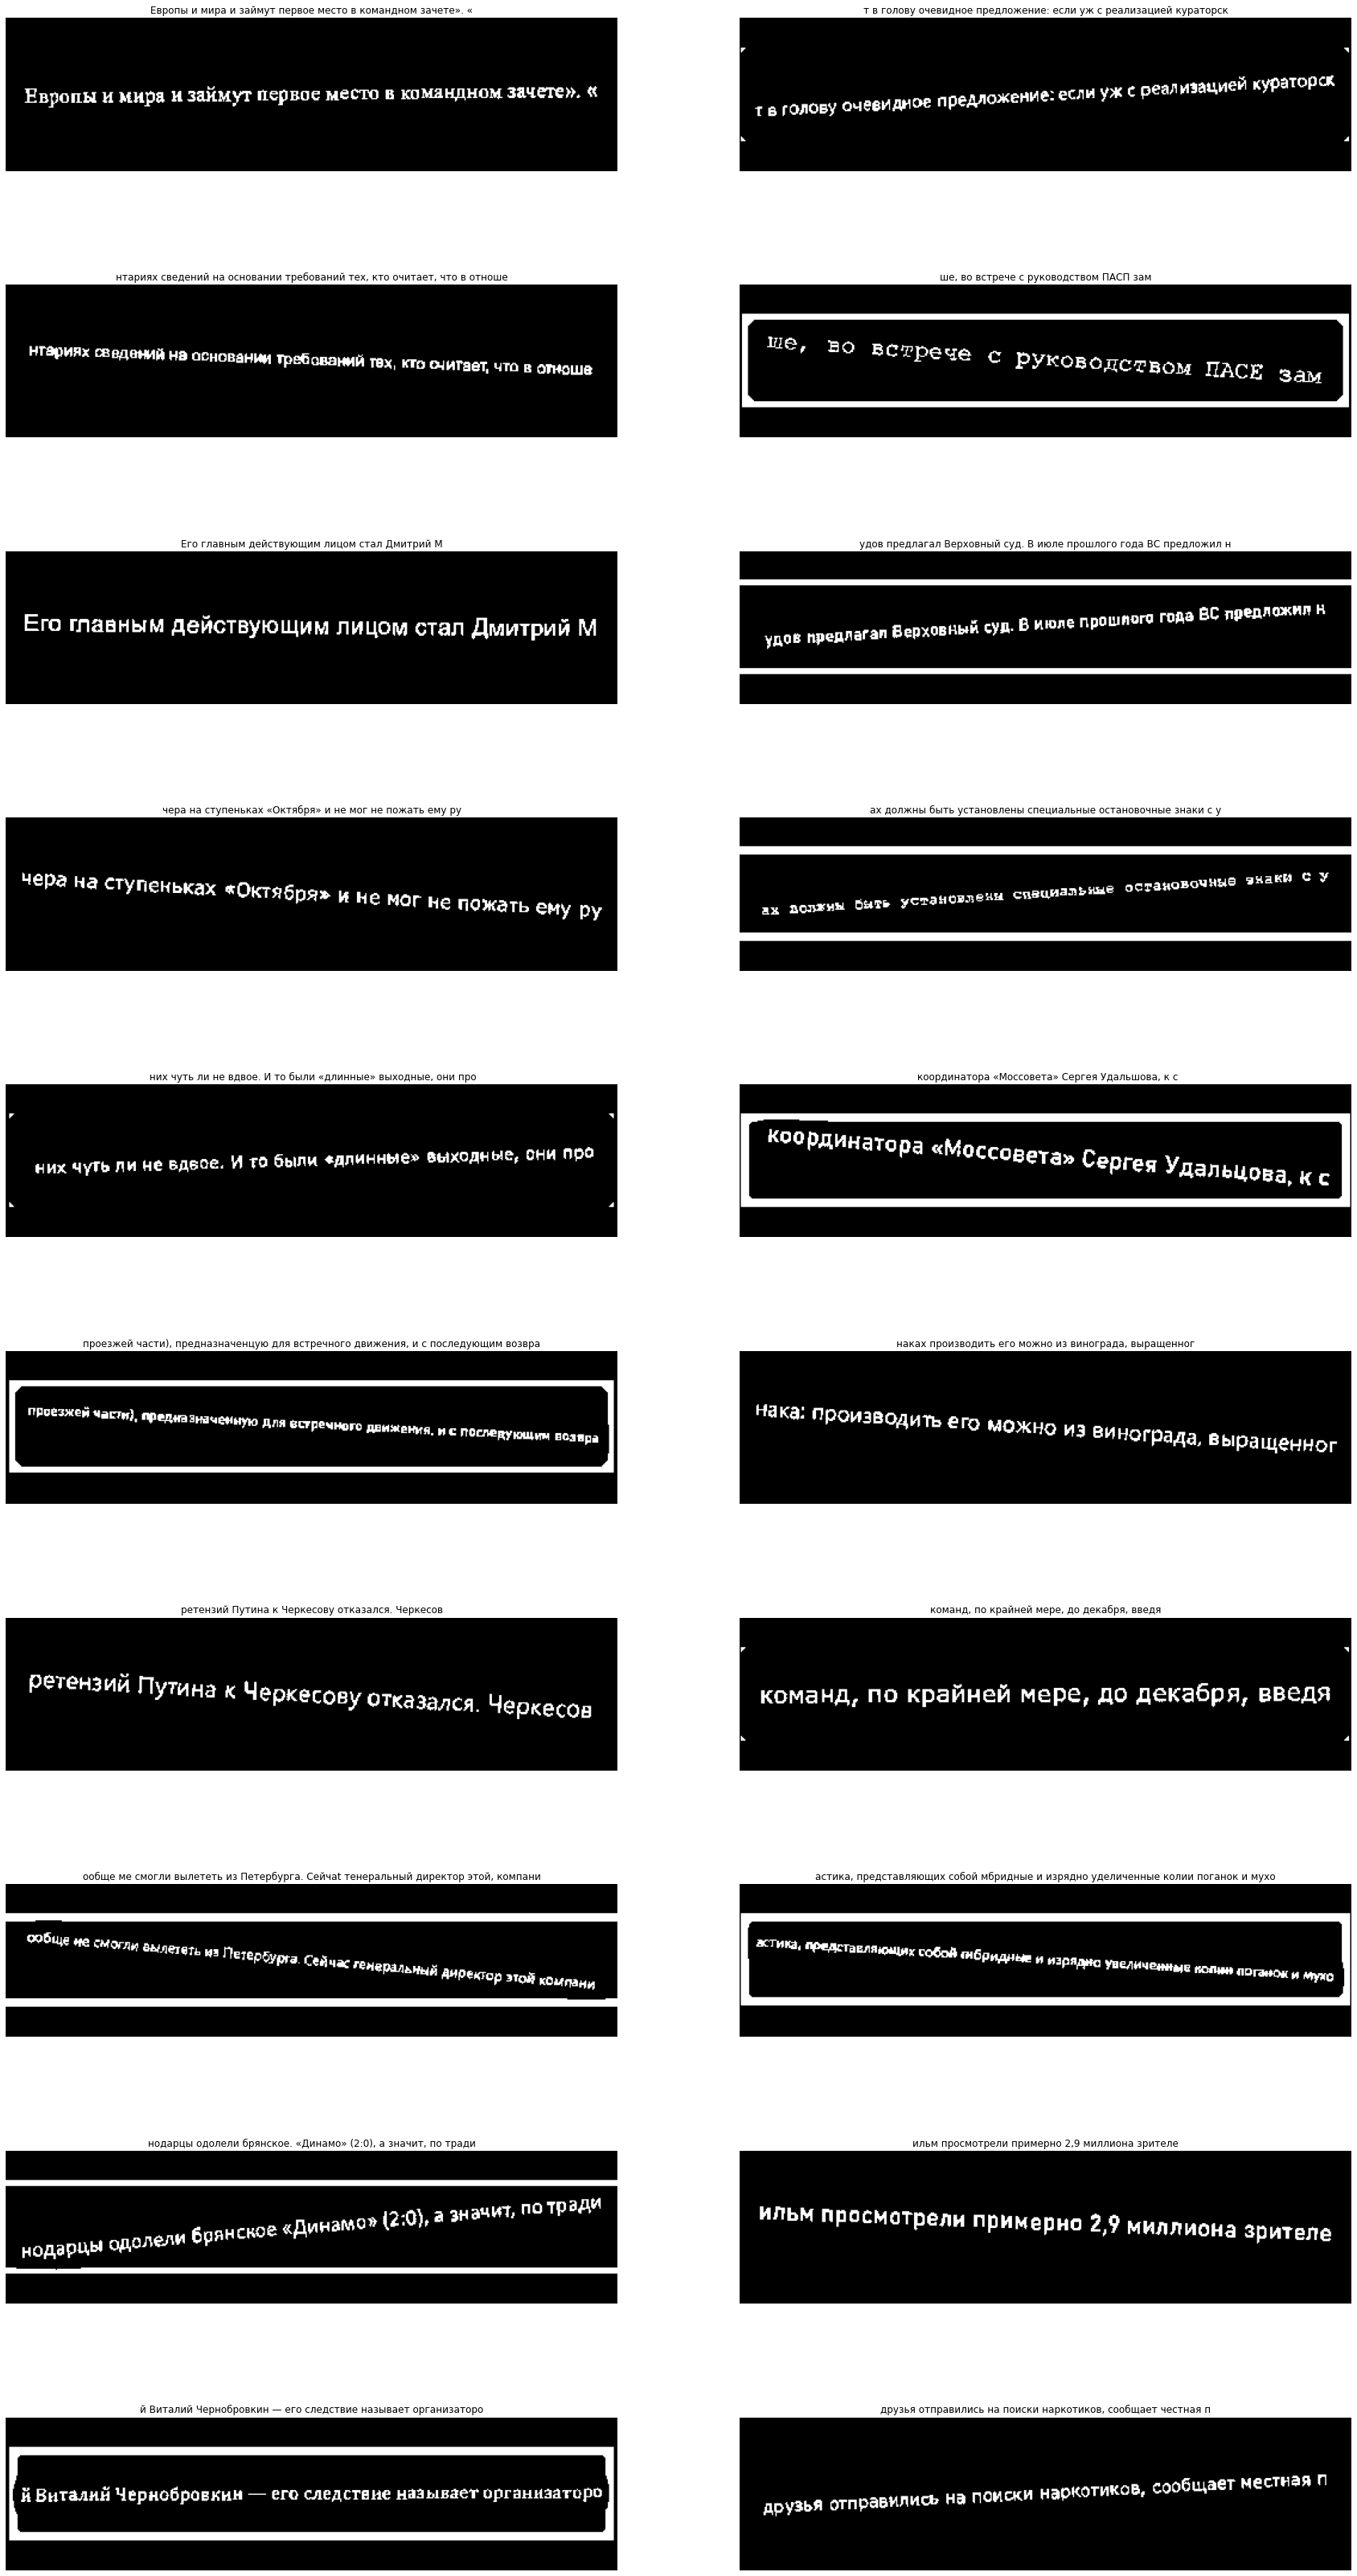

In [ ]:
fig, axes = plt.subplots(figsize=(30, 60), ncols=2, nrows=10)

test_X = np.array(printed_X_test).astype('int')

for i in range(20):
  axes[i // 2, i % 2].imshow(cv2.rotate(
      (test_X[i]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
      cmap='gray')
  axes[i // 2, i % 2].set_title(
      f'{predicts_printed[i]}')
  axes[i // 2, i % 2].axis("off")

# **Распознавание рукописного текста**

Загрузка модели для предсказания рукописного текста

In [ ]:
# -------- Указать свой путь до файла Model_L1.h5 на гугл диске ----------

model = load_model('drive/MyDrive/Task1/Model_L1.h5', custom_objects={'CTCLoss' : CTCLoss, 'CERMetric': CERMetric})

Предсказания текста

In [ ]:
predicts_handwritten = model.predict(np.array(handwritten_X_test))
predicts_handwritten = decode_text_l1(predicts_handwritten)

for i in predicts_handwritten[:10]:
  print(i)

178/178 [==============================] - 19s 102ms/step
оружия
мерного
единяет
металличдемт
Которое
принимать
культа ятона
Оеним
врений
многочленов


Вывод примеров распознавания

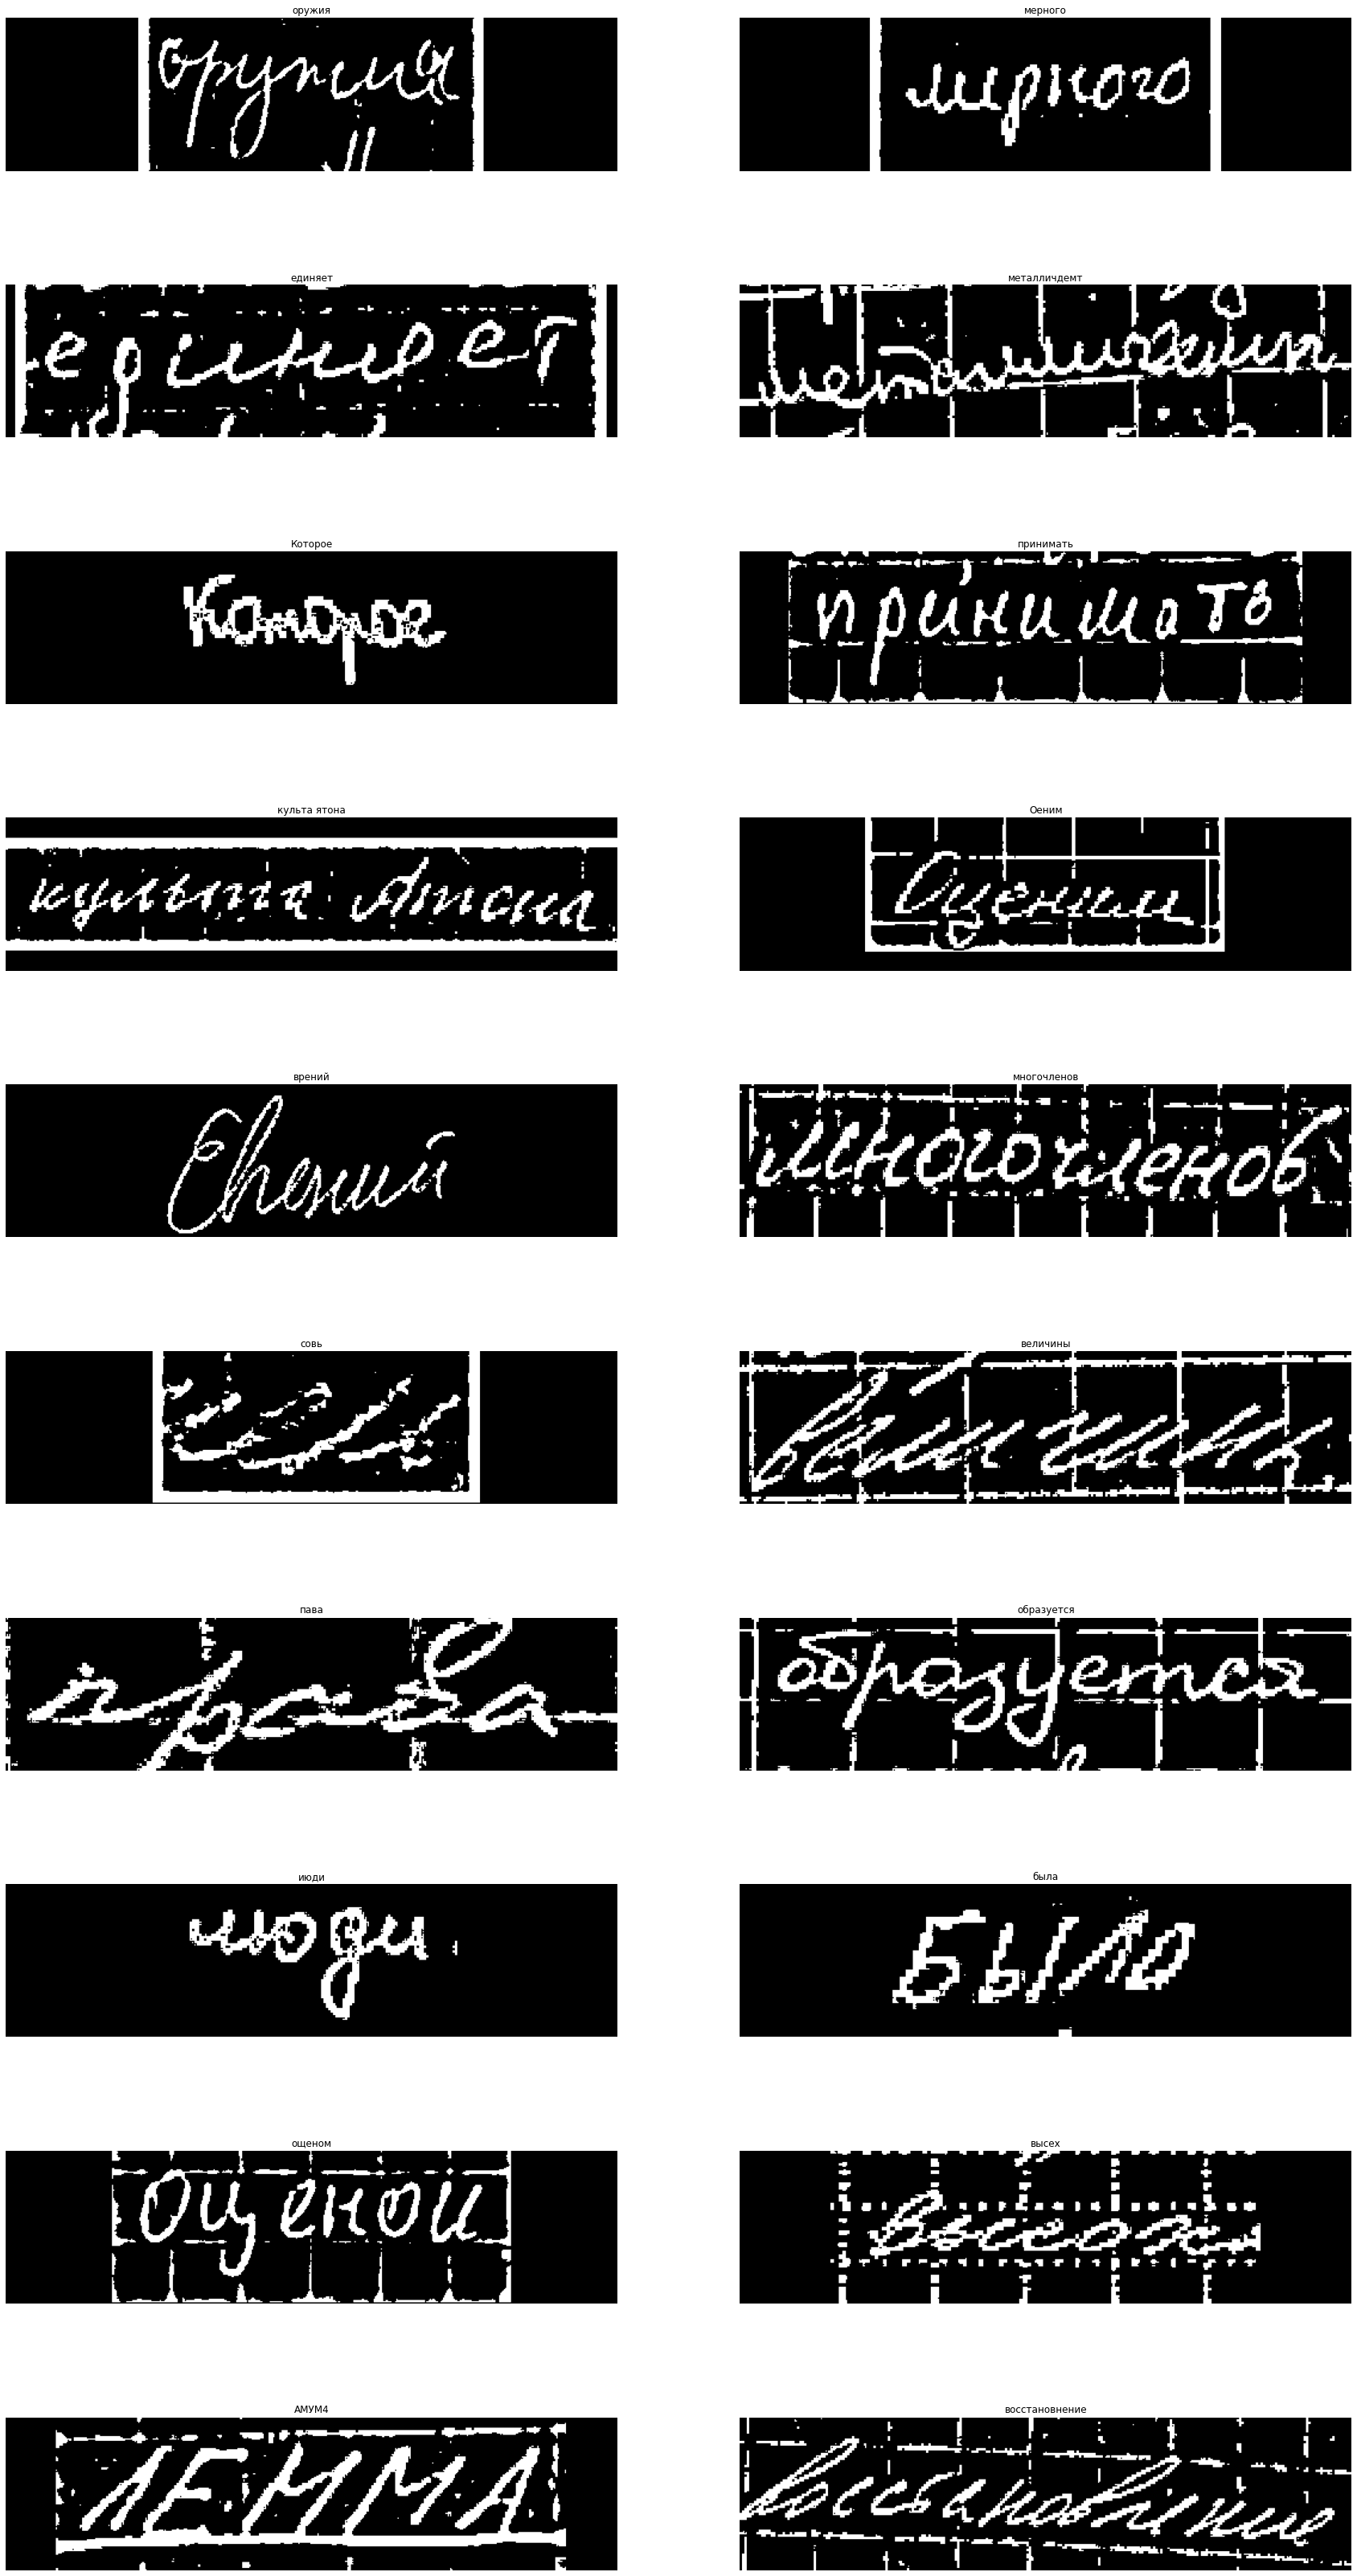

In [ ]:
fig, axes = plt.subplots(figsize=(30, 60), ncols=2, nrows=10)

test_X = np.array(handwritten_X_test).astype('int')

for i in range(20):
  axes[i // 2, i % 2].imshow(cv2.rotate(
      (test_X[i]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
      cmap='gray')
  axes[i // 2, i % 2].set_title(
      f'{predicts_handwritten[i]}')
  axes[i // 2, i % 2].axis("off")

In [ ]:
len(predicts_handwritten)

5669

In [ ]:
result = []
i, j = 0, 0
for name, label in predict_dict.items():
    if label == 0:
        result.append([name, label, predicts_printed[i]])
        i += 1
    else:
        result.append([name, label, predicts_handwritten[j]])
        j += 1

In [ ]:
df = pd.DataFrame(result, columns=["name", "label", "text"])
df.to_csv("drive/MyDrive/Task1/result.csv", sep=',')